# A PyNets Primer in Python and Bash

## Scope of this tutorial
Docker/Singularity containers are the preferable way to run PyNets because the compute environment will include all optional dependencies and will yield fully reproducible numerical precision. To keep things simple for this demonstration, however, let's begin by just installing PyNets in a virtual environment and then run the workflow manually on some example BIDS data. The scope of this tutorial will cover single-subject workflows. For more examples (i.e. including usage with docker/singularity), see: https://pynets.readthedocs.io/en/latest/usage.html

## What PyNets is and isn't
Although we will explore the package interactively in the code that follows, keep in mind that PyNets is not a library like its core dependencies (Nipype, Dipy, Nilearn, Networkx). Rather, it is a *workflow* for mining connectome ensembles that uses these libraries in an integrated fashion. More specifically, PyNets is a *post-processing* workflow, which means that it expects dMRI and fMRI data inputs that have already been scrubbed of artifact (i.e. to maximize SNR), thereby creating a 'baseline' of data-wrangling. This helps ensure that analytically-relevant resampling (e.g. normalization to a template, smoothing, high/low-pass filtering, ROI masking, etc.) can be left to PyNets for meaningful connectome optimization, whilst also providing flexibility to the user to test their own unique hypotheses (e.g. the impact of various fmri-denoising strategies on downstream connectome reliability). fmriprep, CPAC, XCP-Engine, dmriprep, qsiprep, etc. are ideal preprocessing pipelines to use in this regard because they operate on BIDS datasets more or less automatically, and thus can easily scale to larger sample-sizes needed to avoid biased prediction.

## Scalability and compute resources
PyNets itself was developed primarily using supercomputers and cloud infrastructures, but it is flexible enough to also run using just a few cores on your local laptop/desktop. Although this tutorial pushes the boundaries of the latter use-case, it is meant to demonstrate what PyNets makes possible in only 0.5-3 hours! Welcome to the exciting new world of connectome ensemble-learning.

## Installation

In [ ]:
%%bash
# Assuming that python3, pip, and FSL are already installed...
# Start a virtual environment and install some dependencies for our lesson.
pip install virtualenv --user
mkdir ~/virtualenvironment 2>/dev/null
virtualenv ~/virtualenvironment/pynets
cd ~/virtualenvironment/pynets/bin
source activate
./pip3 install -U gdown fury ipykernel # for downloading data, running pynets, and some 3d viz
./pip3 install pynets=='1.0.0'

In [ ]:
%%bash
# The only GUI-based visualizer that I continue to use (personally) is fsleyes,
# which I find to be immensely intuitive, especially for fine-grained QC of overlays.
# But feel free to use an image viewer of your choice. Future PyNets versions will
# include html-style reports (ala fmriprep/qsiprep/dmriprep).
# For macs, download this link for fsleyes:
if  [ ! -f /tmp/FSLeyes-latest-macos.tar.gz ] || [ ! -d ~/virtualenvironment/FSLeyes.app ]; then
    wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fsleyes/FSLeyes-latest-macos.tar.gz -O /tmp/FSLeyes-latest-macos.tar.gz
    tar -xzf /tmp/FSLeyes-latest-macos.tar.gz -C ~/virtualenvironment
fi

rm /tmp/FSLeyes-latest-macos.tar.gz
# For Linux, downnload the appropriate precompiled build from https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLeyes

# Fetch sample preprocessed data

Now we can download a minimal dataset from OASIS that includes preprocessed, multimodal fMRI and dMRI data.

*Note*: Normally, we could just use a dataset from datalad or from s3 (which will download automatically using an s3:// file path prefix if your AWS credentials are properly configured!). See `pynets_cloud` CLI , with examples here: https://pynets.readthedocs.io/en/latest/usage.html#quickstart

In [ ]:
%%bash
# Now we create an output directory for the derivatives of the pipeline (if one doesn't exist already).
if  [ ! -d ~/Downloads/.pynets ]; then
    mkdir ~/Downloads/.pynets
fi

# And download the data to a generic "derivatives" directory.
if  [ ! -f ~/Downloads/.pynets/test_oasis.tar.gz ]; then
    cd ~/Downloads/.pynets
    gdown https://drive.google.com/uc?id=1beEoc_Pdk6OBDYc80mBDTvUhcUny9Gu3 -O ~/Downloads/.pynets/test_oasis.tar.gz
else
    cd ~/Downloads/.pynets
fi

mkdir -p ~/Downloads/.pynets/derivatives/preprocessed/sub-OAS31172 2>/dev/null
tar -xzf test_oasis.tar.gz -C derivatives/preprocessed/sub-OAS31172
rm test_oasis.tar.gz

Now we construct a command-line call for a single subject from the data we just downloaded. We can do this in two ways -- (1) using the `pynets_bids` API since our sample data is in BIDS format and can be queried using pybids; (2) with the `pynets` API for comparison.
So, for run 1 of session d0407 from subject OAS31172, lets sample an ensemble of 144 functional connectome estimates (1 models x 6 thresholds x 2 smoothing values x 2 high-pass filter thresholds x 3 atlases x 2 time-series extraction methods).

In [1]:
%%bash
dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`

# BIDS way using a pre-configured .json file that specifies how we want the pipeline to run.
# We can view this file to get an idea of what it contains:
cat ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_bold.json

# Next we initiate the `pynets_bids` CLI (note the inclusion of a run_label since the BOLD acquisitions for this dataset contain two runs):%%bash
~/virtualenvironment/pynets/bin/pynets_bids "$abs_dir"/.pynets/derivatives/preprocessed "$abs_dir"/.pynets/derivatives participant func --participant_label OAS31172 --session_label d0407 --run_label 1 -config ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_bold.json

# *Note that the configuration in `bids_config_bold.json` is equivalent to running the following (non-BIDS) CLI call that does not require a config file:
# ~/virtualenvironment/pynets/bin/pynets "$abs_dir"/.pynets/derivatives -id OAS31172_d0407_1 -mod 'partcorr' -min_thr 0.20 -max_thr 0.80 -step_thr 0.10 -sm 0 4 -hp 0 0.028 -a 'BrainnetomeAtlasFan2016' 'atlas_harvard_oxford' 'destrieux2009_rois' -es 'mean' 'variance' -anat "$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/anat/sub-OAS31172_ses-d0407_run-01_T1w.nii.gz -func "$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/func/sub-OAS31172_ses-d0407_task-rest_run-01_bold.nii.gz -plug 'MultiProc' -work '/tmp/pynets_work' -mst -plt -embed

{
    "dwi": {
            "dg": "None",
            "ml": "None",
            "mod": "None"
        },
    "func": {
            "ct": "None",
            "hp": "['0', '0.028']",
            "k": "None",
            "mod": "['partcorr']",
            "sm": "['0', '4']",
            "es": "['mean', 'variance']"
        },
    "gen": {
            "a":  "['BrainnetomeAtlasFan2016', 'atlas_harvard_oxford', 'destrieux2009_rois']",
            "bin":  "False",
            "df":  "False",
            "dt":  "False",
            "embed":  "True",
            "max_thr":  0.80,
            "min_thr":  0.20,
            "mplx":  "['0']",
            "mst":  "True",
            "n":  "None",
            "norm": "['6']",
            "ns":  "None",
            "p":  "['1']",
            "plt":  "True",
            "spheres":  "False",
            "step_thr":  0.10,
            "thr":  "None",
            "vox":  "'2mm'"
        }
}

BIDS API


Obtaining Derivatives Layout...

Arguments parsed from

# Viewing outputs

In [2]:
%%bash
cd ~/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/func
ls

tree

BrainnetomeAtlasFan2016
atlas_harvard_oxford
destrieux2009_rois
summary
.
├── BrainnetomeAtlasFan2016
│   ├── BrainnetomeAtlasFan2016_tmp_reor-RAS_res-2mm.nii.gz
│   ├── embeddings
│   │   ├── estimator_embedding-ASE_BrainnetomeAtlasFan2016_whole_brain.joblib
│   │   └── gradients_embedding-ASE_BrainnetomeAtlasFan2016_whole_brain.npy
│   ├── figures
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_model-partcorr_nodetype-parc_extract-mean_thr-0.2.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_model-partcorr_nodetype-parc_extract-mean_thr-0.3.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_model-partcorr_nodetype-parc_extract-mean_thr-0.4.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_model-partcorr_nodetype-parc_extract-mean_thr-0.5.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_model-partcorr_nodetype-parc_extract-mean_thr-0.6.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-func_

Lets do a bit of quality-control to ensure, for example, that the inverse warping of the destrieux2009_rois atlas from template-space to native T1w anatomical space is valid.

In [ ]:
%%bash
t1w_image=`ls /tmp/pynets_work/*/*/meta_wf_*/fmri_connectometry*/register_node/reg/imgs/*t1w_brain.nii.gz | head -1`
atlas_in_t1w_image=`ls /tmp/pynets_work/*_wf_single_subject_fmri*/wf_single_*/meta_wf_*/fmri_connectometry_*/_atlas_destrieux2009_rois/register_atlas_node/atlas_destrieux2009_rois/*_gm.nii.gz | head -1`

#~/virtualenvironment/FSLeyes.app/Contents/*/fsleyes "$t1w_image" "$atlas_in_t1w_image" -cm 'random' &


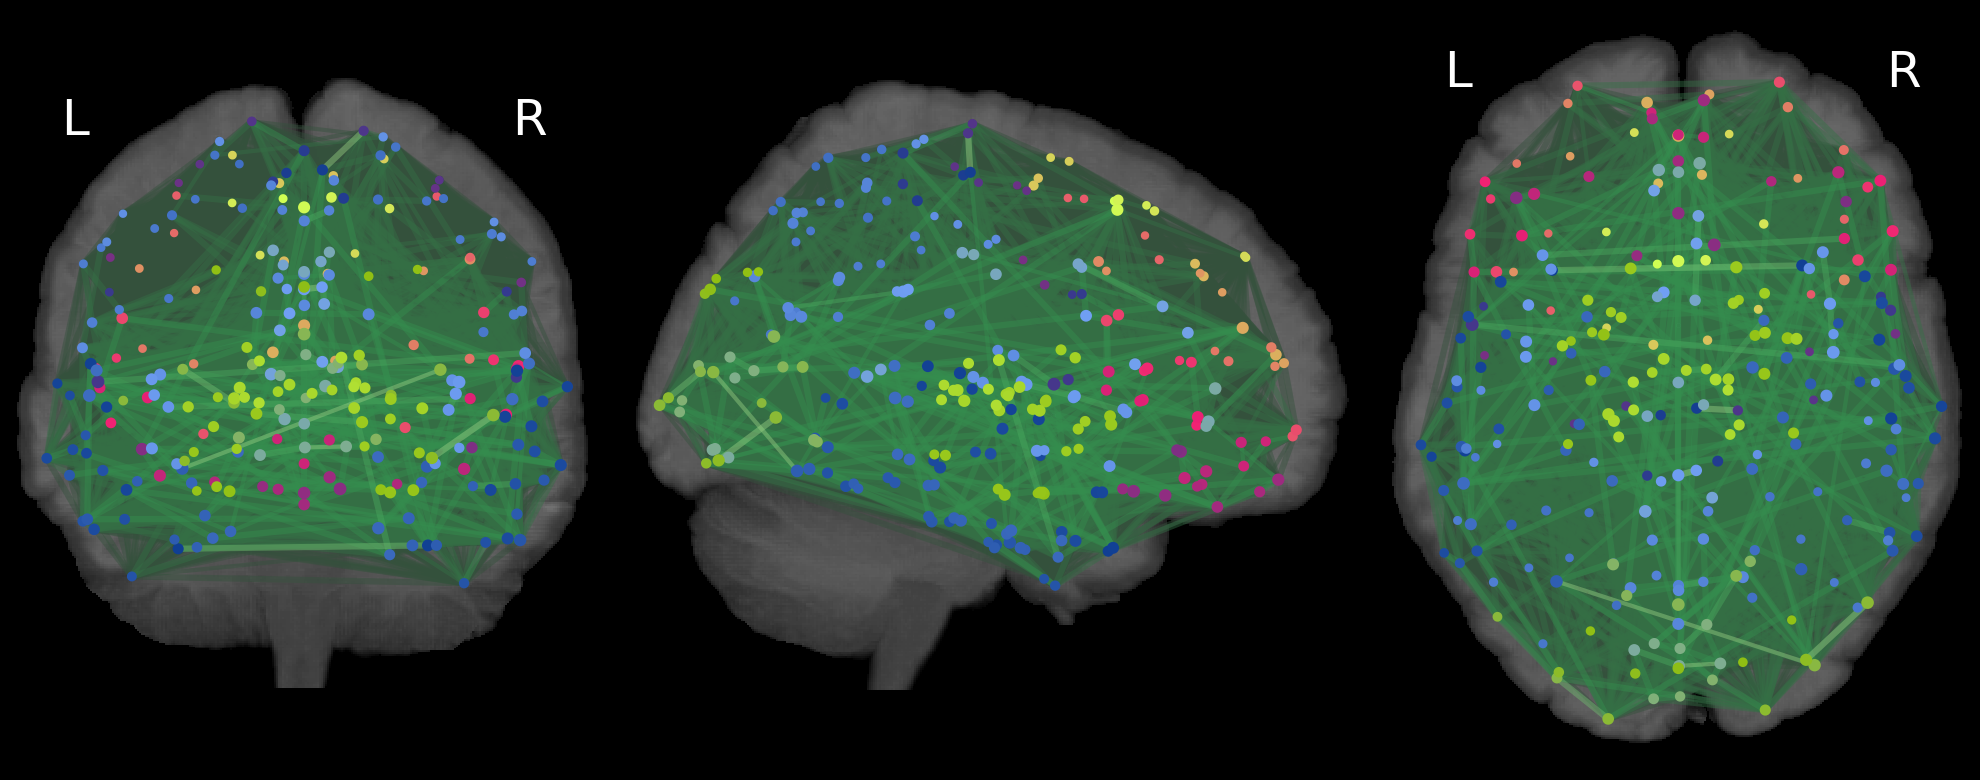

In [4]:
import glob
from pathlib import Path
from IPython.display import Image
Image(filename=glob.glob(str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/figures/glassbrain_*.png')[0])


Above is a glass brain depiction of bilateral regions of the Brainnetome atlas (Fan et al., 2016) using a partial correlation estimator, 4 fwhm smoothing, 0.028Hz high-pass filter, based on variance of the node-extracted time-series, with 20% post-hoc thresholding using the Minimum-Spanning Tree (MST) method. The latter method serves as an anti-fragmentation device that ensures we can prevent isolated (i.e. disconnected) nodes that can violate certain graph theoretical assumptions.

In the visualization, node size conveys the level of node importance (smaller is lower eigenvector centrality) and node color corresponds to hierarchical Louvain community affiliation (8 distinct communities found).

The below adjacency matrix depicts a single connectome estimate, with community affiliation.

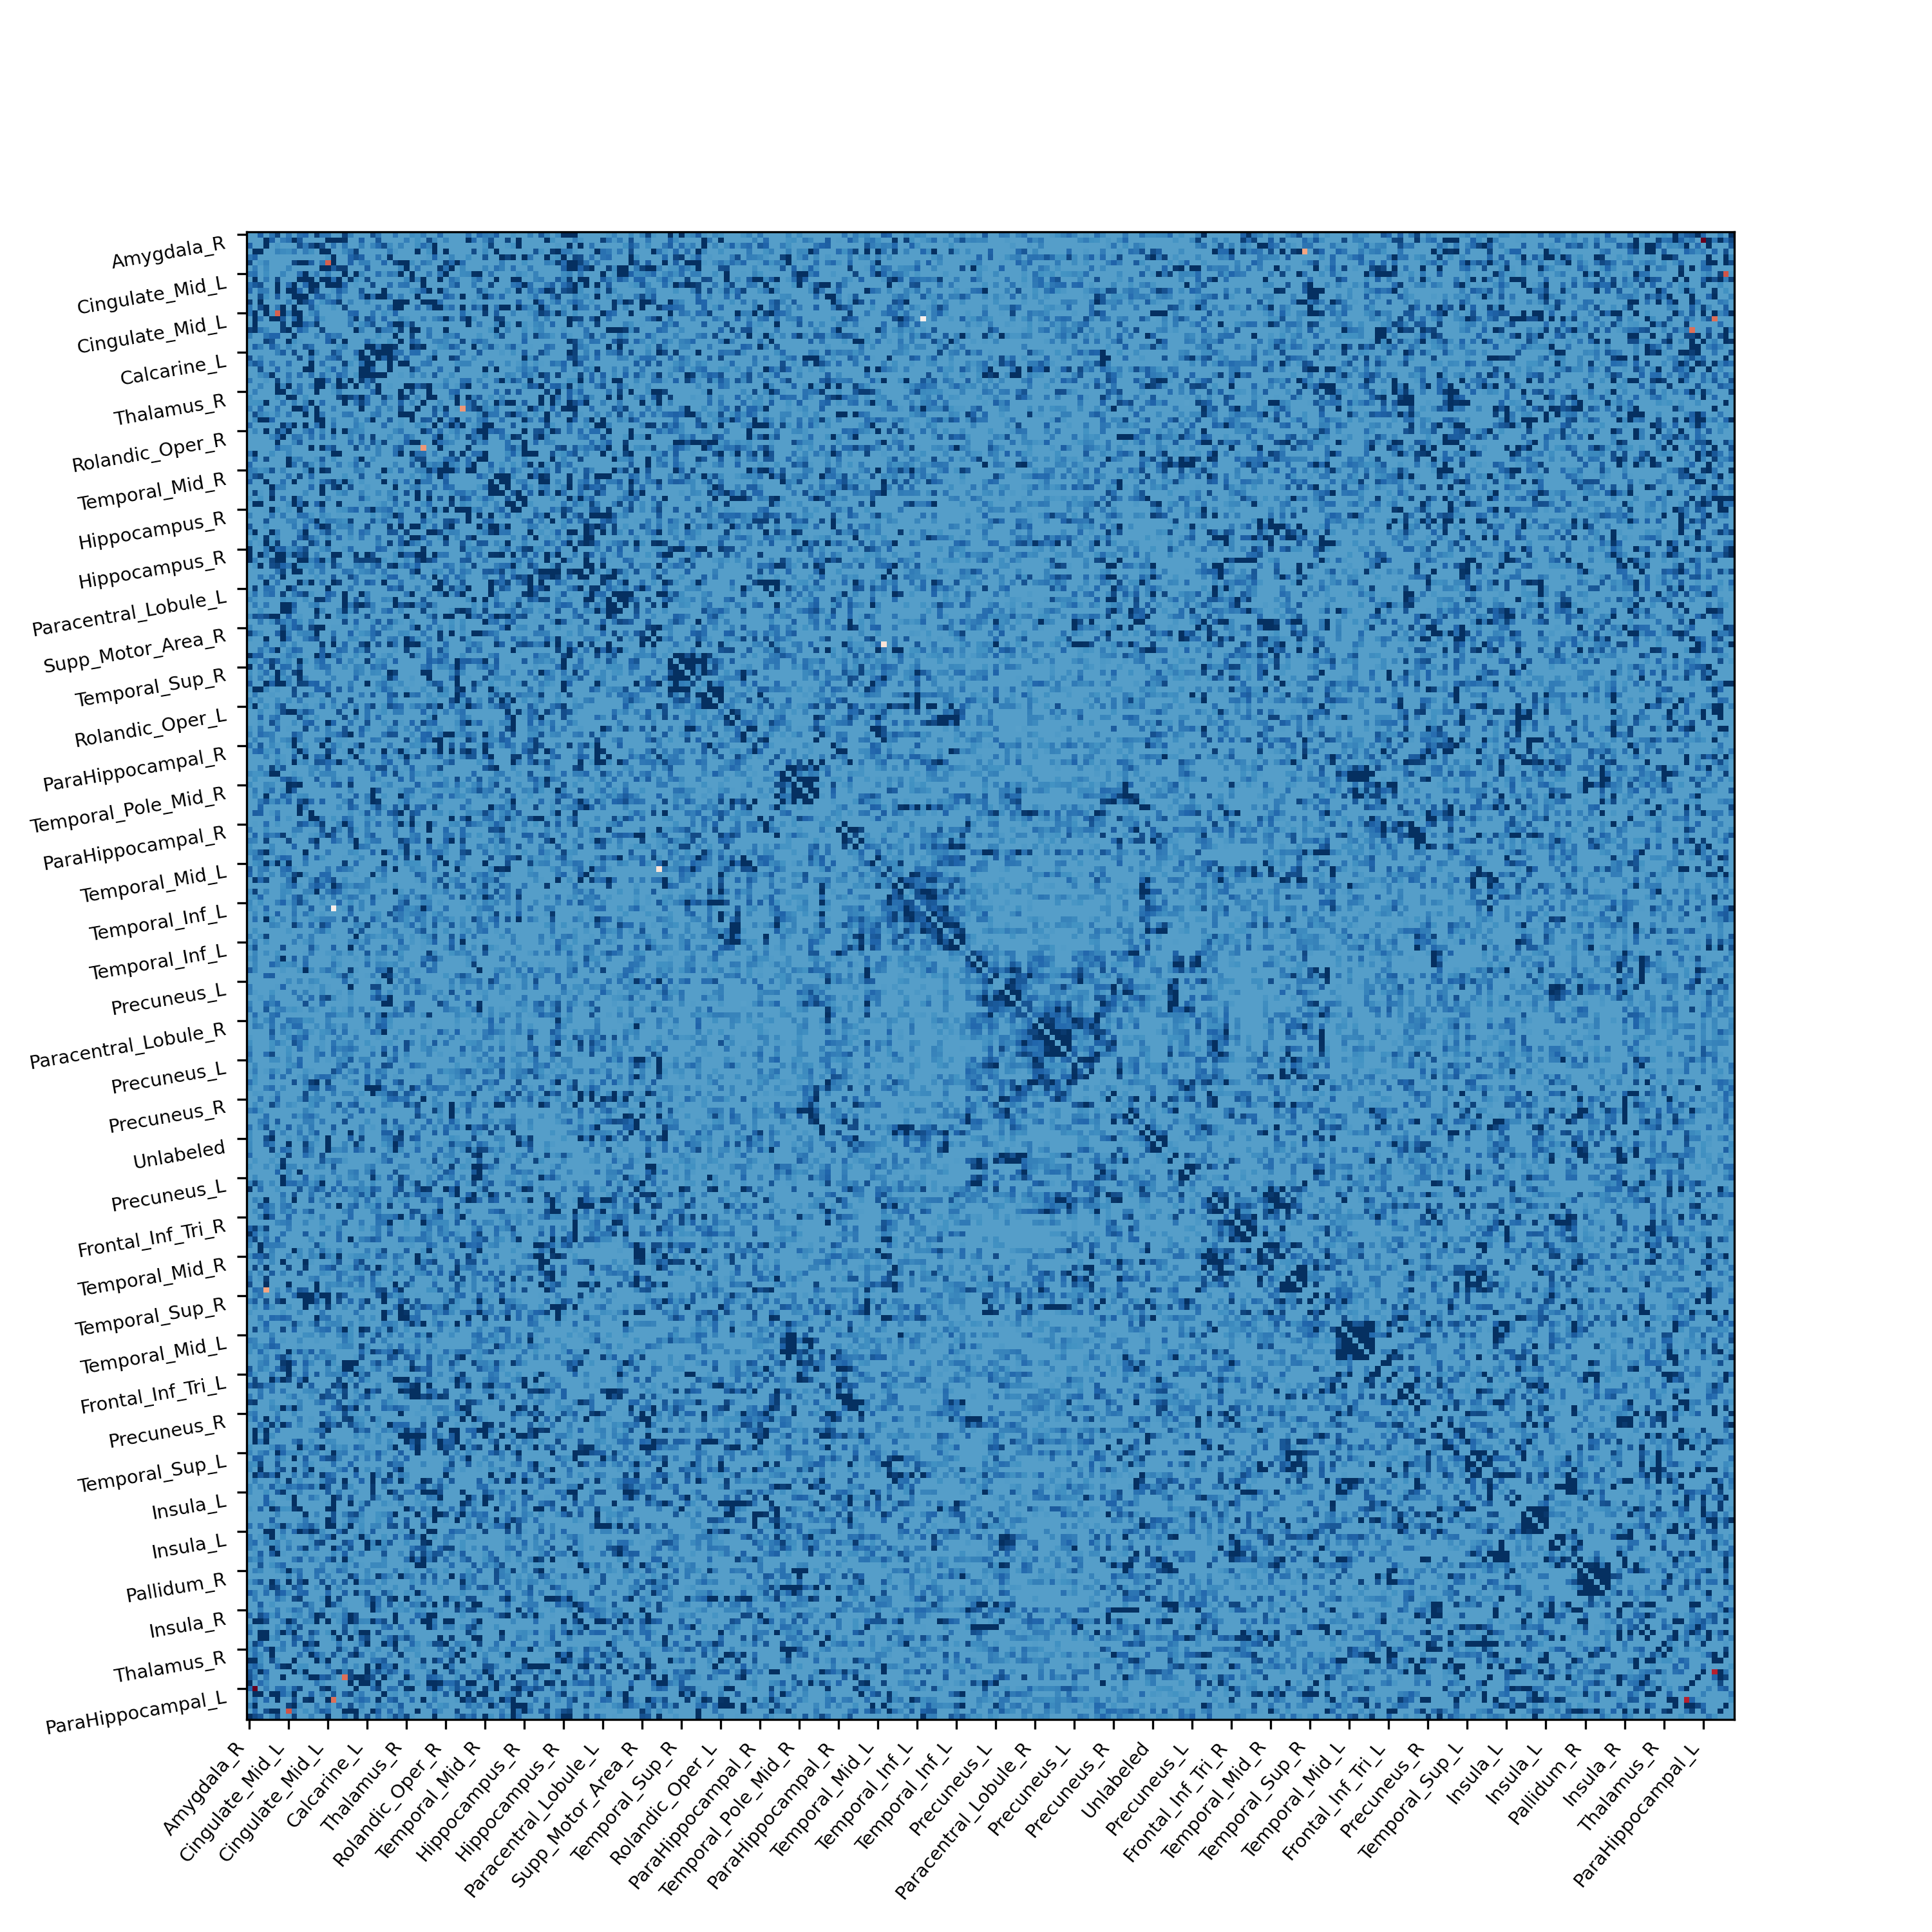

In [5]:
Image(filename=glob.glob(str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/figures/*')[0])

We could also look at the mean connectome (i.e. across all 144 estimates) -- what we might from here on out refer to as an **omnetome** as well:

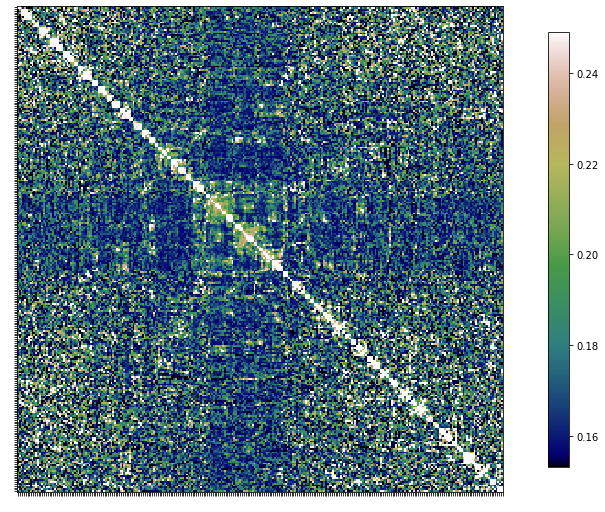

In [22]:
%matplotlib inline
import glob
import numpy as np
from matplotlib import pyplot as plt
from nilearn.plotting import plot_matrix
from pynets.core.thresholding import standardize, binarize

mats = [np.load(i) for i in glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/graphs/*.npy')]

mean_mat = standardize(np.mean(mats, axis=0))

mean_mat_bin = binarize(mean_mat)
mean_mat = np.nan_to_num(np.multiply(mean_mat, mean_mat_bin))

plot_matrix(
    mean_mat,
    figure=(10, 10),
    labels=[' ']*len(mean_mat),
    vmax=np.percentile(mean_mat[mean_mat > 0], 95),
    vmin=np.percentile(mean_mat[mean_mat > 0], 5),
    reorder="average",
    auto_fit=True,
    grid=False,
    colorbar=True,
    cmap='gist_earth',
)
plt.show()

As you can see, we get a much more information-rich graph. This graph, unlike the first, now represents a new *distribution* of connectomes, that, by virtue of its plurality of views, more exhaustively samples from the true *population* of networks in this individual that may exhibit connectivity, across the whole brain as a region of interest, at any point in time during the course of the 5-10 minute resting-state time-series.

# Collecting Outputs
So, we explored the outputs of our connectome ensemble visually, but let's take a closer look at our omnetome's topology. To do this, we run another workflow using the `pynets_collect` CLI, which collects the various graph topological metrics extracted from each of the connectome estimates in our ensemble.

In [1]:
%%bash

dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`
~/virtualenvironment/pynets/bin/pynets_collect -basedir "$abs_dir"/.pynets/derivatives/pynets -modality 'func'



PyNets Version:
0.9.999c


200714-18:55:13,794 nipype.workflow INFO:
	 Generated workflow graph: /tmp/work/pynets_out_collection/load_pd_dfs/graph.png (graph2use=colored, simple_form=True).

Running with {'n_procs': 11, 'memory_gb': 10, 'scheduler': 'mem_thread'}

200714-18:55:13,990 nipype.workflow INFO:
	 Workflow load_pd_dfs settings: ['check', 'execution', 'logging', 'monitoring']
200714-18:55:13,995 nipype.workflow INFO:
	 Running in parallel.
200714-18:55:13,998 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 10.00/10.00, Free processors: 11/11.
200714-18:55:14,998 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 9.80/10.00, Free processors: 10/11.
                     Currently running:
                       * load_pd_dfs.build_subject_dict_node
200714-18:55:15,878 nipype.workflow INFO:
	 [Node] Setting-up "load_pd_dfs.build_subject_dict_node" in "/private/tmp/work/pynets_out_collection/load_pd_d

In [2]:
import pathlib
from pathlib import Path
import pandas as pd

# Now we can load a dataframe containing all the AUC topological graph metrics calculated for this particular subject's run:
p = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/func_group_topology_auc/sub-OAS31172_ses-d0407_topology_auc_clean.csv'
df_individual = pd.read_csv(p, index_col=False)
df_individual

# Note that if we were to sample connectomes from multiple subjects, the previous pynets_collect CLI would
# simply append new rows to the summary `all_subs_neat_func.csv` dataframe.
p = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/all_subs_neat_func.csv'
df_group = pd.read_csv(p, index_col=False)
df_group

id  \
0  sub-OAS31172_ses-d0407   

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_betweenness_centrality_auc  \
0                                           0.003027                                                                                                 

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_clustering_auc  \
0                                           0.025381                                                                                     

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_degree_centrality_auc  \
0                                           0.199142                                                                                            

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_diversity_coefficient_auc  \
0                                            0.87062                                                                                                

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_eigenvector_centrality_auc  \
0                                           0.060805                                                                                                 

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_local_clustering_nodewise_auc  \
0                                           0.228168                                                                                                    

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_participation_coefficient_auc  \
0                                           0.703913                                                                                                    

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_average_shortest_path_length_auc  \
0                                           0.057896                                                                                               

   BrainnetomeAtlasFan2016_partcorr_template-MNI152_T1_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST_auc_global_efficiency_auc  \
0                                           18.26927                                                                                    

   ...  \
0  ...   

   destrieux2009_rois_partcorr_template-MNI152_T1_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST_auc_average_betweenness_centrality_auc  \
0                                           0.005503                                                                                                         

   destrieux2009_rois_partcorr_template-MNI152_T1_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST_auc_average_clustering_auc  \
0                                           0.042515                                                                                             

   destrieux2009_rois_partcorr_template-MNI152_T1_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST_auc_average_degree_centrality_auc  \
0                                           0.198796                                                                                                    

   destrieux2009_rois_partcorr_template-MNI152_T1_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST_auc_average_diversity_coefficient_auc  \
0                                           0.827166                                                                                                        

   destrieux2009_rois_partcorr_template-MNI152_T1_nodety

The below multiplot depicts distributions of average graph topological metrics, calculated using Area-Under-the-Curve (AUC) across our window of multiple thresholds, for the ensemble of 144 connectomes sampled. As you can visually discern, topology varies considerably across estimates.

In [1]:
%matplotlib inline
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from pynets.plotting.plot_gen import plot_graph_measure_hists

csv_all_metrics = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/func_group_topology_auc/sub-OAS31172_ses-d0407_topology_auc_clean.csv'

out = plot_graph_measure_hists(csv_all_metrics)
out.show()

Making model plots...


<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

We could also plot the omnetome embeddings to visualize lower-dimensional latent positions of the ensemble corresponding to each distinct graph resolution

In [5]:
%matplotlib inline
from graspy.plot import pairplot
import glob
import os
import numpy as np
from matplotlib import pyplot as plt

omnetomes = [[np.load(i), os.path.basename(i).split('.npy')[0]] for i in glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/func/*/embeddings/*omnetome.npy')]

for grad, title in omnetomes:
    plot = pairplot(grad, title=title + '_Functional')

# Structural Connectometry

And now we construct a command-line call for the same subject, but using their dMRI data instead. This time, we should ideally use a higher voxel resolution (1mm) since we are working with microstructure data, but this would increase runtime by as much as 50%, which would be better saved for HPC environments. For demonstration purposes, we will therefore downsample our data slightly and work in 2mm voxel resolution.

So, for run 1 of session d0407 from subject OAS31172, lets sample an ensemble of 72 structural connectome estimates (1 diffusion model type x 6 thresholds x 2 direction-getting methods x 2 minimum streamline length thresholds x 3 atlases.

In [2]:
%%bash
%%capture

# Again, get the absolute paths to files and directories we will use.
# The CLI's in PyNets do NOT accept relative paths.
dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`

# BIDS way using a pre-configured .json file that specifies how we want the pipeline to run.
# We can view this file to get an idea of what it contains:
cat ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_dwi.json

# Next we initiate the `pynets_bids` CLI:
~/virtualenvironment/pynets/bin/pynets_bids "$abs_dir"/.pynets/derivatives/preprocessed "$abs_dir"/.pynets/derivatives participant dwi --participant_label OAS31172 --session_label d0407 -config ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_dwi.json

# *Note that the configuration in `bids_config_dwi.json` is equivalent to running the following (non-BIDS) CLI call that does not require a config file:
#~/virtualenvironment/pynets/bin/pynets "$abs_dir"/.pynets/outputs -mod 'csa' -min_thr 0.20 -max_thr 0.80 -step_thr 0.10 -dg 'det' 'prob' -ml 20 0 -a 'BrainnetomeAtlasFan2016' 'atlas_harvard_oxford' 'destrieux2009_rois' -anat ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/anat/sub-OAS31172_ses-d0407_run-01_T1w.nii.gz" -dwi ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.nii.gz" -bval ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.bval" -bvec ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.bvec" -id OAS31172_d0407_1 -plug 'MultiProc' -work '/tmp/pynets_work' -mst -plt -vox '2mm' -embed


{
    "dwi": {
            "dg": "['det', 'prob']",
            "ml": "['0', '20']",
            "mod": "['csa']"
        },
    "func": {
            "ct": "None",
            "hp": "None",
            "k": "None",
            "mod": "None",
            "sm": "None",
            "es": "None"
        },
    "gen": {
            "a":  "['BrainnetomeAtlasFan2016', 'atlas_harvard_oxford', 'destrieux2009_rois']",
            "bin":  "False",
            "df":  "False",
            "dt":  "False",
            "embed":  "True",
            "max_thr":  0.80,
            "min_thr":  0.20,
            "mplx":  "['0']",
            "mst":  "True",
            "n":  "None",
            "norm": "['6']",
            "ns":  "None",
            "p":  "['1']",
            "plt":  "True",
            "spheres":  "False",
            "step_thr":  0.10,
            "thr":  "None",
            "vox":  "'2mm'"
        }
}

BIDS API


Obtaining Derivatives Layout...

Arguments parsed from bids_config.json:


bash: line 1: fg: no job control
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d0407.run_tracking_node".
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d0407.run_tracking_node".
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d0407.streams2graph_node".
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d0407.streams2graph_node".
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d0407.run_tracking_node".
INFO:nipype.workflow:[Node] Finished "wf_single_sub_OAS31172_d0407_dmri_20200714_185803.meta_wf_OAS31172_d0407.dmri_connectometry_OAS31172_d

# Viewing outputs

In [3]:
%%bash
cd ~/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi
ls
tree

BrainnetomeAtlasFan2016
atlas_harvard_oxford
destrieux2009_rois
summary
.
├── BrainnetomeAtlasFan2016
│   ├── BrainnetomeAtlasFan2016_tmp_reor-RAS_res-2mm.nii.gz
│   ├── embeddings
│   │   ├── estimator_embedding-ASE_BrainnetomeAtlasFan2016_whole_brain.joblib
│   │   └── gradients_embedding-ASE_BrainnetomeAtlasFan2016_whole_brain.npy
│   ├── figures
│   │   ├── adjacency-communities_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thr-0.2.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thr-0.3.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thr-0.4.png
│   │   ├── adjacency-communities_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thr-0.5.png
│   

Lets do a bit of quality-control to ensure, for example, that the inverse warping of the harvard_oxford atlas from template-space to native DWI anatomical space is valid.

In [ ]:
%%bash
t1w_dwi_image=`ls /tmp/work/*/*/meta_wf_*/dmri_connectometry*/register_node/dmri_reg/reg/imgs/t1w_in_dwi.nii.gz | head -1`
atlas_in_t1w_dwi_image=`ls ~/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/parcellations/atlas_harvard_oxford_dwi_track.nii.gz | head -1`
density_map=`ls ~/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/tractography/*.nii.gz | head -1`

#~/virtualenvironment/FSLeyes.app/Contents/*/fsleyes "$t1w_dwi_image" "$atlas_in_t1w_dwi_image" -cm 'random' "$density_map" -cm 'copper' &


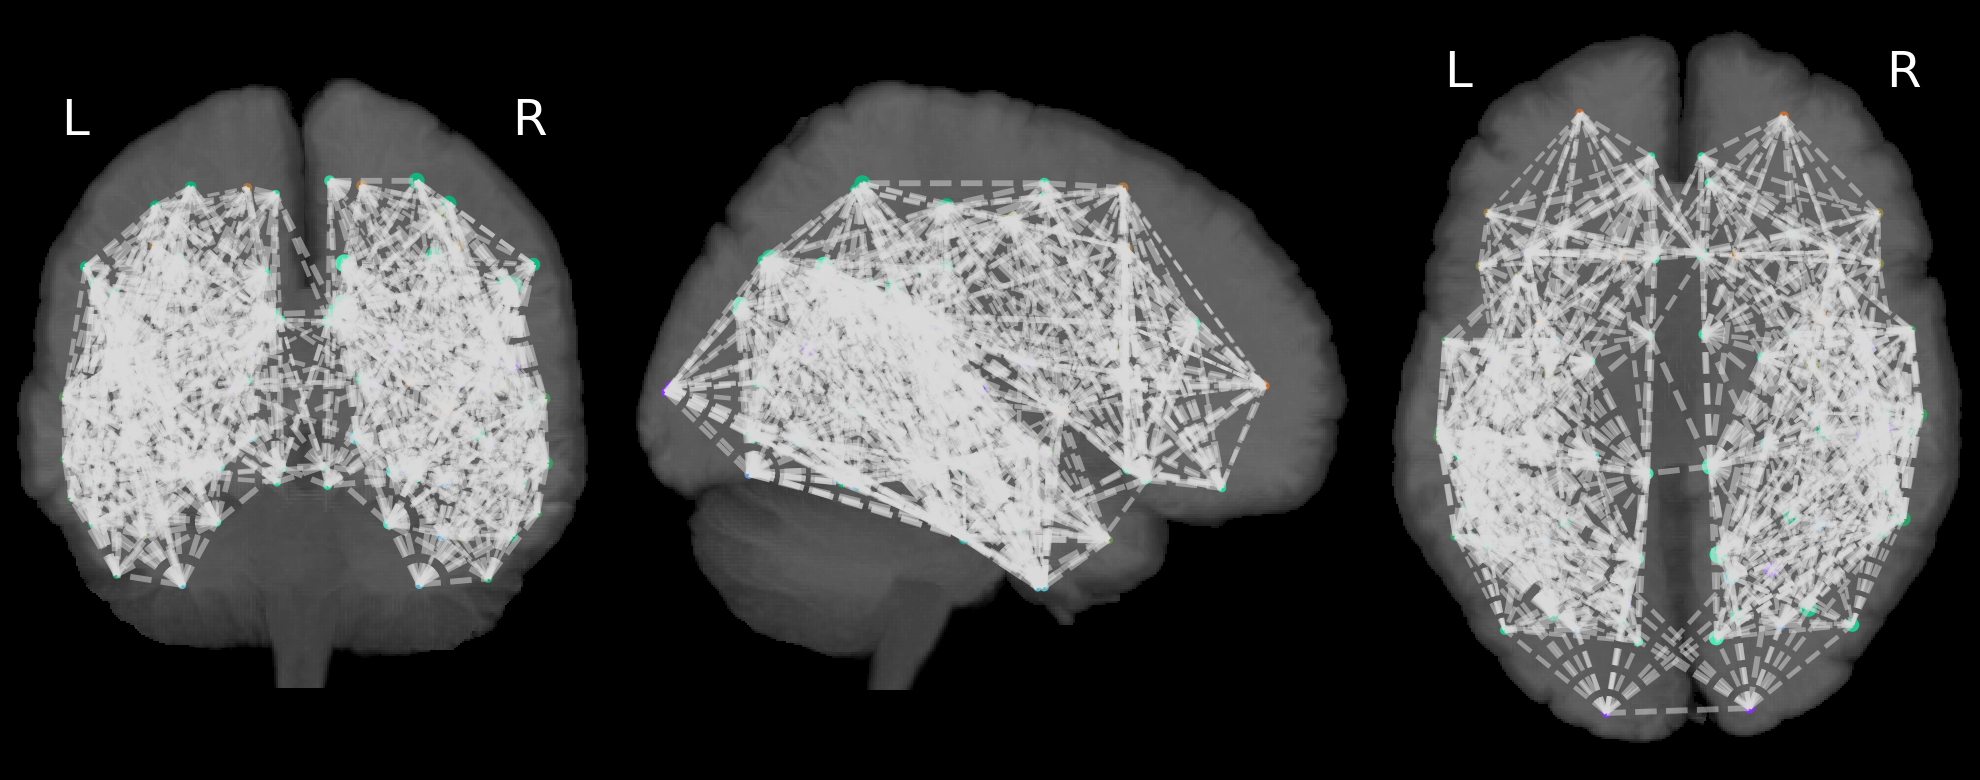

In [6]:
import glob
from IPython.display import Image
Image(filename=glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/figures/glassbrain_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-prob_minlength-20_thr-0.2.png')[0])

Above is a glass brain depiction of regions of the Harvard-Oxford atlas using a tensor model of diffusion, deterministic tractography, a minimum fiber length of 20, with 80% post-hoc thresholding using the Minimum-Spanning Tree (MST) method.
As before, node size here conveys the level of node importance (smaller is lower eigenvector centrality) and node color corresponds to hierarchical Louvain community affiliation (only two distinct communities found). Unlike in the functional case, however, edges are here depicted with dotted white lines to differentiate them from functional edges, which carry a different meaning.

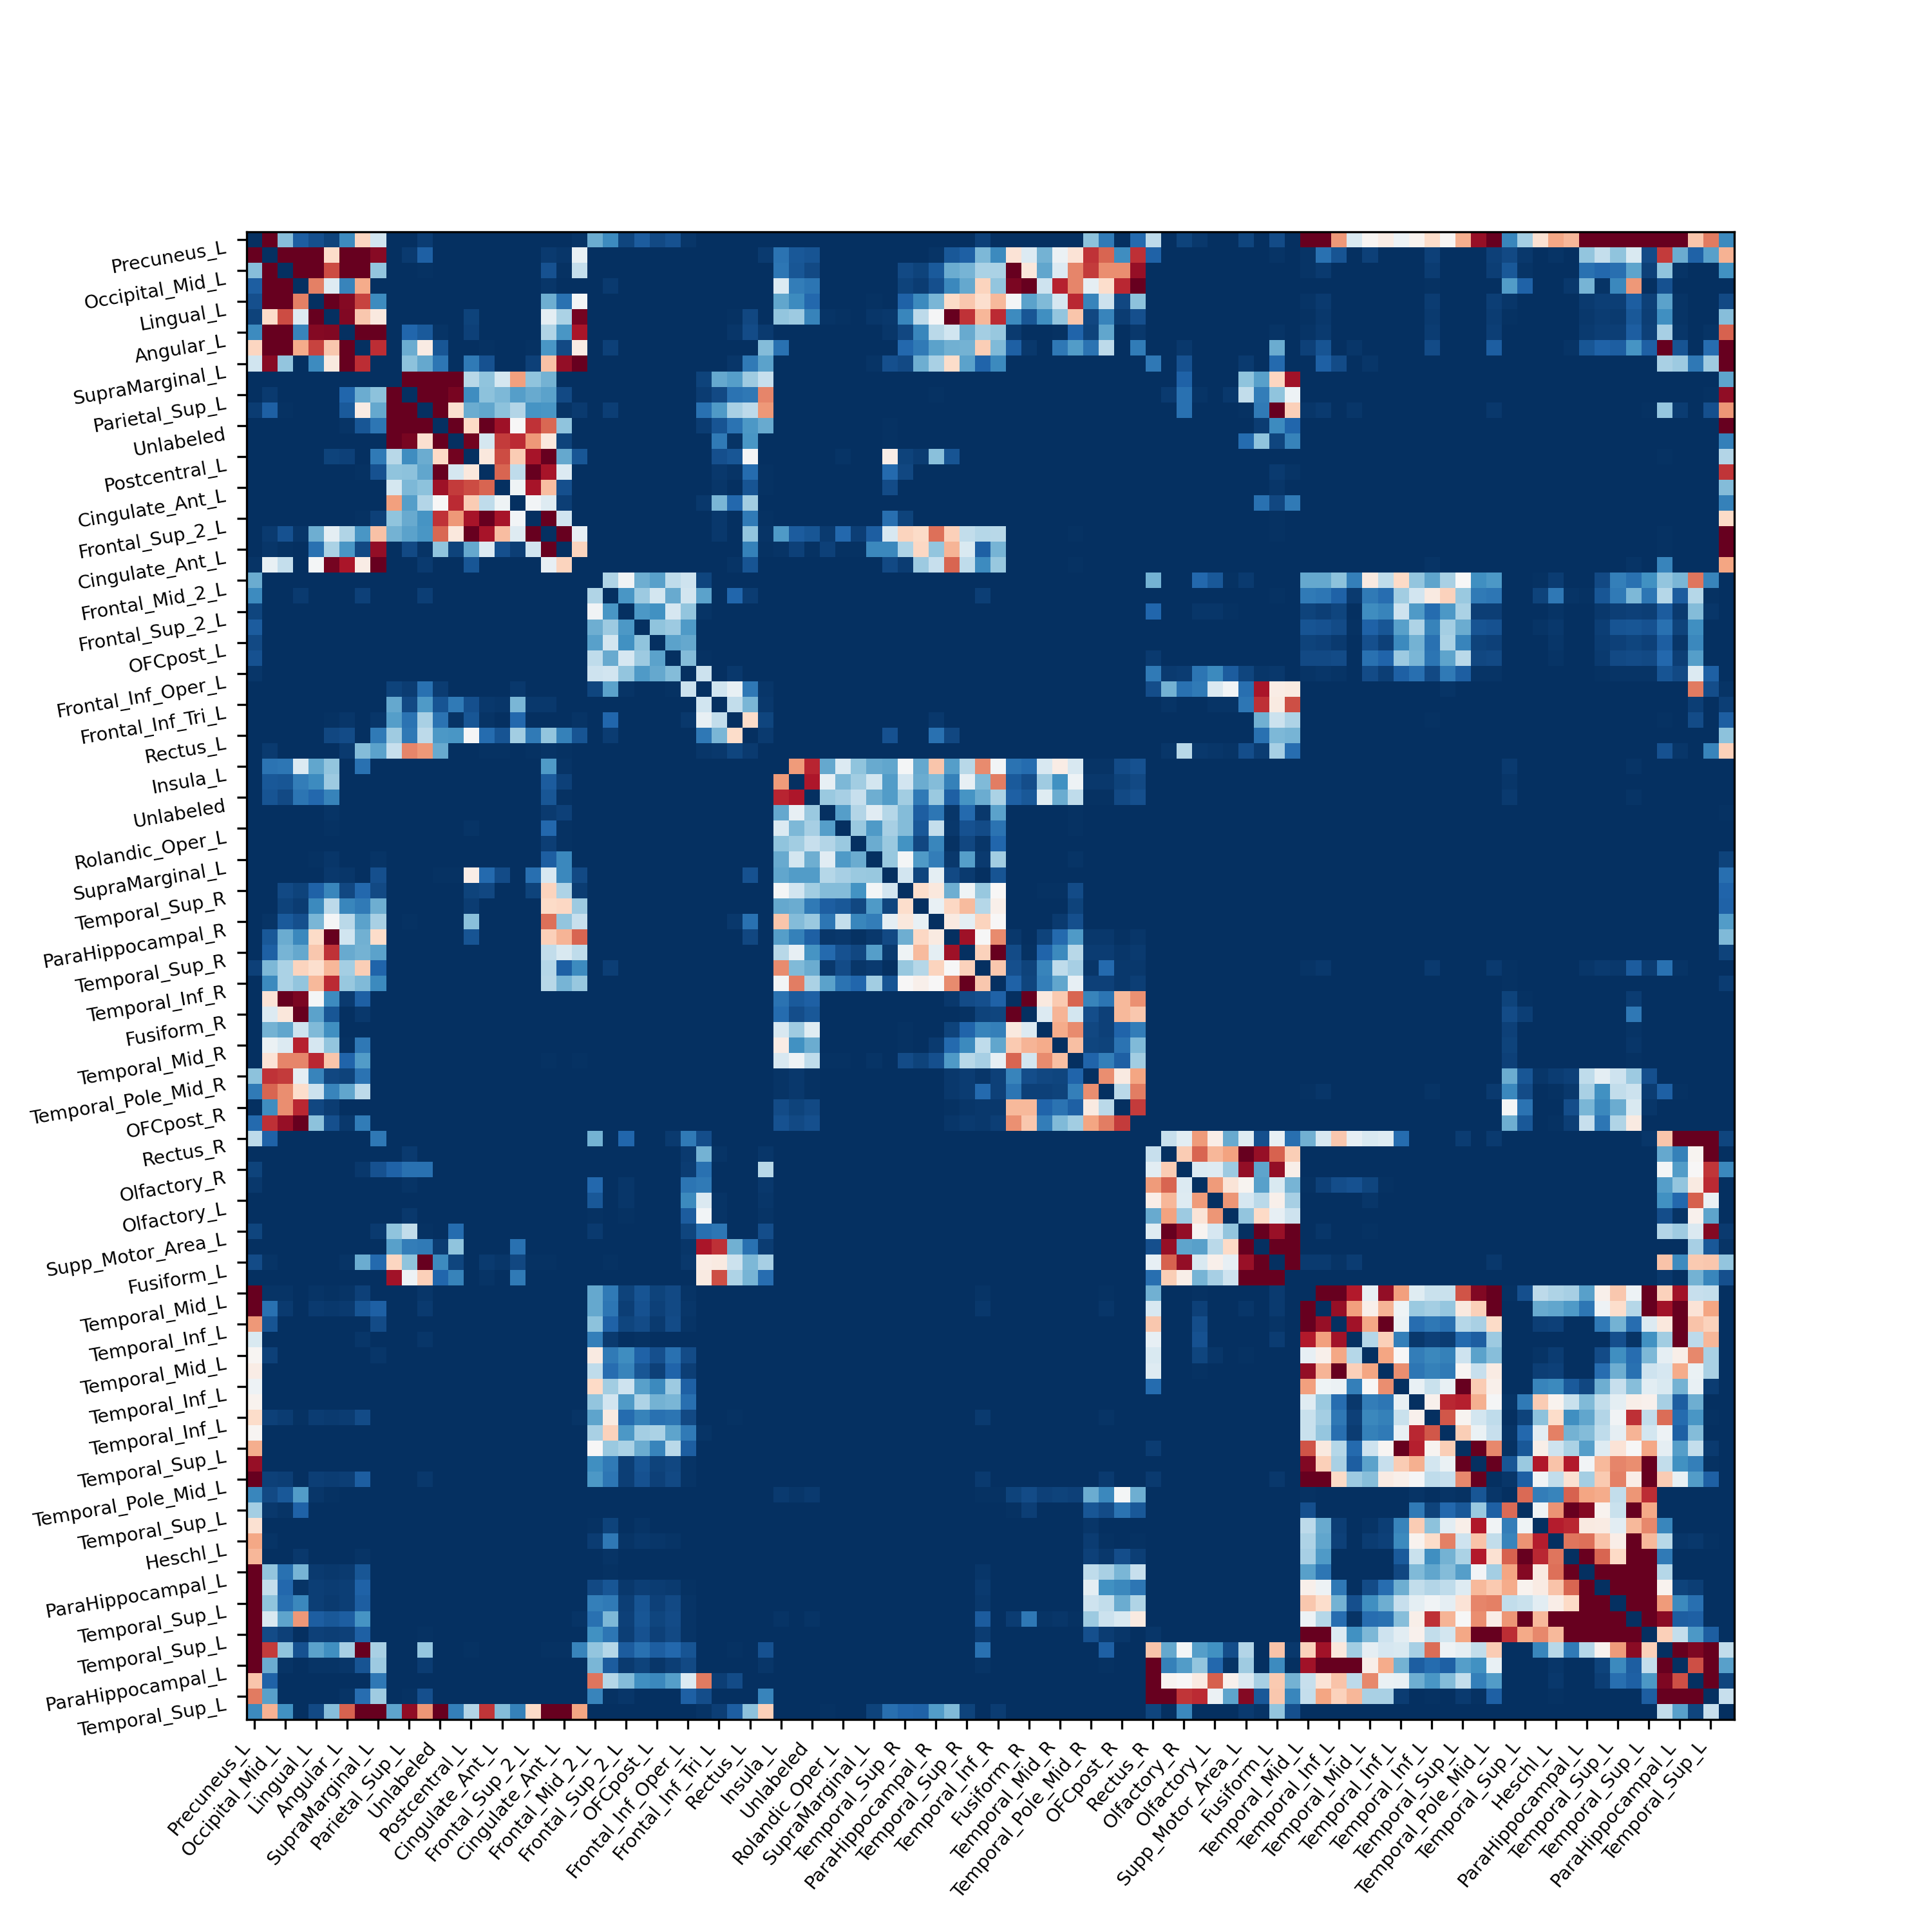

In [9]:
Image(filename=glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/figures/adjacency_OAS31172_d0407_modality-dwi_model-csa_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thr-0.8.png')[0])


The above adjacency matrix depicts a single connectome estimate, with community affiliation. But we could also look at a structural omnetome (i.e. based on FA-weighted fiber counts) across all 72 independent connectome estimations. Note that by default pynets only samples 20,000 streamlines whose endpoints intersect with at least two parcellation regions after all tissue/waymask/minimum-length filtering. This keeps runtimes down to <30 minutes for a single structural connectometry sample with comparable ensemble sampling runtimes to the functional connectometry pipeline. Bear in mind, too, that cumulatively across our ensemble here, we are *actually* sampling 20,000 x 72 = 1.4 million streamlines.

In fact if wanted, we could QC the tractogram to view these streamlines alongside the parcellation overlay(s), as is done below:

In [ ]:
%matplotlib notebook
import pathlib
from pathlib import Path
from pynets.plotting.plot_gen import view_tractogram
streams = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/tractography/streamlines_csa_50000_parc_curv-[40_30]_step-[0.1_0.2_0.3_0.4_0.5]_dg-prob_ml-0.trk'
atlas = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/parcellations/atlas_harvard_oxford_dwi_track.nii.gz'

#view_tractogram(streams, atlas)


Whereas in the functional connectometry case, we examined the mean connectome across estimates, here we might choose to examine the max connectome specifically, since structural connectomes are inherently sparser.

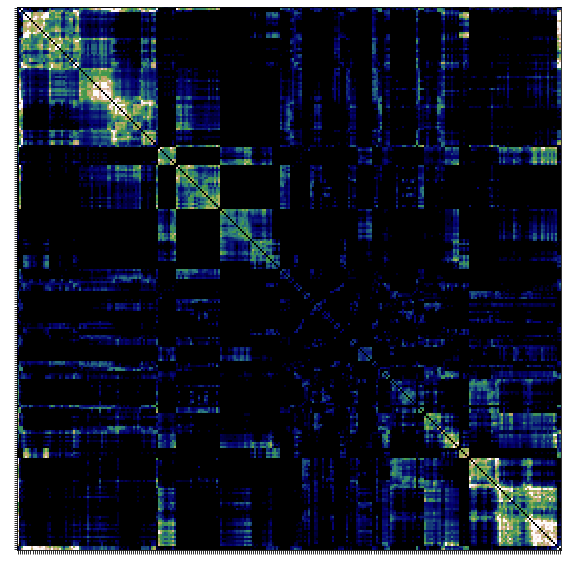

In [14]:
%matplotlib inline
import pickle
import glob
import numpy as np
from matplotlib import pyplot as plt
from nilearn.plotting import plot_matrix
from pynets.core.thresholding import standardize, binarize

mats = [np.load(i) for i in glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/BrainnetomeAtlasFan2016/graphs/*.npy')]

max_mat = standardize(np.max(mats, axis=0))

max_mat_bin = binarize(max_mat)
max_mat = np.nan_to_num(np.multiply(max_mat, max_mat_bin))

plot_matrix(
    max_mat,
    figure=(10, 10),
    labels=[' ']*len(max_mat),
    vmax=np.percentile(max_mat[max_mat > 0], 99),
    vmin=np.percentile(max_mat[max_mat > 0], 5),
    reorder="average",
    auto_fit=True,
    grid=False,
    colorbar=False,
    cmap='gist_earth',
)
plt.show()

As you can see, we get a much more information-rich graph. This graph, unlike the first, now represents a new *distribution* of connectomes, that, by virtue of its plurality of views, more exhaustively samples from the true *population* of networks in this individual that may exhibit connectivity, across the whole brain as a region of interest.

# Collecting Outputs
Now, we explored the outputs of our connectome ensemble visually, but let's take a closer look at the actual topological data. To do this, we run another workflow using the `pynets_collect` CLI.

In [15]:
%%bash

dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`
pynets_collect -basedir "$abs_dir"/.pynets/derivatives/pynets -modality 'dwi'



PyNets Version:
0.9.999c


200714-22:32:53,60 nipype.workflow INFO:
	 Generated workflow graph: /tmp/work/pynets_out_collection/load_pd_dfs/graph.png (graph2use=colored, simple_form=True).

Running with {'n_procs': 11, 'memory_gb': 9, 'scheduler': 'mem_thread'}

200714-22:32:54,62 nipype.workflow INFO:
	 Workflow load_pd_dfs settings: ['check', 'execution', 'logging', 'monitoring']
200714-22:32:54,69 nipype.workflow INFO:
	 Running in parallel.
200714-22:32:54,72 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 9.00/9.00, Free processors: 11/11.
200714-22:32:55,74 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 8.80/9.00, Free processors: 10/11.
                     Currently running:
                       * load_pd_dfs.build_subject_dict_node
200714-22:32:58,611 nipype.workflow INFO:
	 [Node] Setting-up "load_pd_dfs.build_subject_dict_node" in "/private/tmp/work/pynets_out_collection/load_pd_dfs/_sub_s

And as before we can view the output data and visualize the various corresponding graph embeddings...

In [16]:
import pathlib
from pathlib import Path
import pandas as pd

# Now we can load a dataframe containing all the AUC topological graph metrics calculated for this particular subject's run:
p = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/dwi_group_topology_auc/sub-OAS31172_ses-d0407_topology_auc_clean.csv'
df_individual = pd.read_csv(p, index_col=False)
df_individual

# Note that if we were to sample connectomes from multiple subjects, the previous pynets_collect CLI would
# simply append new rows to the summary `all_subs_neat_func.csv` dataframe.
p = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/all_subs_neat_dwi.csv'
df_group = pd.read_csv(p, index_col=False)
df_group

id  \
0  sub-OAS31172_ses-d0407   

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_betweenness_centrality_auc  \
0                                           0.004201                                                                                                                                

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_clustering_auc  \
0                                           0.049556                                                                                                                    

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_degree_centrality_auc  \
0                                           0.183204                                                                                                                           

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_diversity_coefficient_auc  \
0                                            0.32817                                                                                                                               

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_eigenvector_centrality_auc  \
0                                           0.057552                                                                                                                                

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_local_clustering_nodewise_auc  \
0                                           0.605185                                                                                                                                   

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_participation_coefficient_auc  \
0                                           0.361679                                                                                                                                   

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_average_shortest_path_length_auc  \
0                                           5.327484                                                                                                                              

   BrainnetomeAtlasFan2016_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-det_minlength-0_thrtype-MST_auc_global_efficiency_auc  \
0                                           0.227127                                                                                                                   

   ...  \
0  ...   

   destrieux2009_rois_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-prob_minlength-20_thrtype-MST_auc_average_betweenness_centrality_auc  \
0                                           0.008322                                                                                                                             

   destrieux2009_rois_csa_template-MNI152_T1_nodetype-parc_samples-20000streams_tracktype-local_directget-prob_minlength-20_thrtype-MST_auc_average_clustering_auc  \
0                                           0.112672                                                                                                                 

   destrieux2009_rois_csa_template-MNI15

Making model plots...


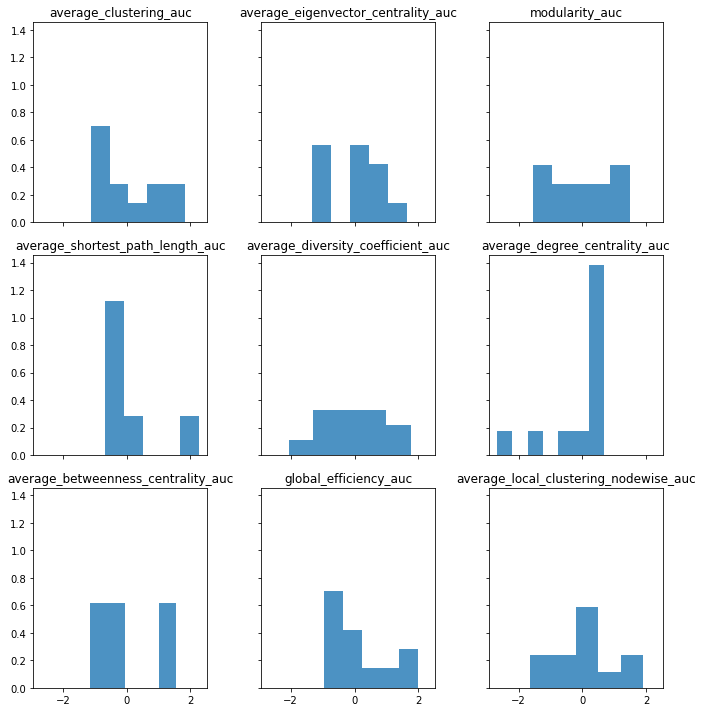

In [17]:
%matplotlib inline
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from pynets.plotting.plot_gen import plot_graph_measure_hists

csv_all_metrics = str(Path('~').expanduser()) + '/Downloads/.pynets/derivatives/pynets/dwi_group_topology_auc/sub-OAS31172_ses-d0407_topology_auc_clean.csv'

out = plot_graph_measure_hists(csv_all_metrics)
out.show()

In [20]:
%matplotlib inline
from graspy.plot import pairplot
import glob
import os
import numpy as np
from matplotlib import pyplot as plt

omnetomes = [[np.load(i), os.path.basename(i).split('.npy')[0]] for i in glob.glob('/Users/*/Downloads/.pynets/derivatives/pynets/sub-OAS31172/ses-d0407/dwi/*/embeddings/*omnetome.npy')]

for grad, title in omnetomes:
    plot = pairplot(grad, title=title + '_Structural')

Later tutorials will cover a variety of additional topics, including how you can deploy PyNets across entire BIDS datasets in a single command-line interface (CLI) call, benchmark and optimize connectome ensembles across diverse analytic scenarios with GridSearchCV integration, along with more advanced topics such as performing and visualizing multiplex graph analysis and embeddings of multimodal connectomes.